<a href="https://colab.research.google.com/github/iamsaksham77/ALY6110/blob/main/Module_5_Group_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PySpark in Google Colab
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("BankAccountFraudDetection").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=be2bfc7d327ce0f730ba30677206ad1e7848ce998ebb37f3f7bc0e1d8ef7baf4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
data = spark.read.csv("Base.csv", header=True, inferSchema=True)
data.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_month

In [ ]:
data.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobil

In [ ]:
#Converting the datatypes
from pyspark.sql.functions import when
data = data.withColumn("email_is_free", when(data["email_is_free"] == 1, True).otherwise(False))
data = data.withColumn("phone_home_valid", when(data["phone_home_valid"] == 1, True).otherwise(False))
data = data.withColumn("phone_mobile_valid", when(data["phone_mobile_valid"] == 1, True).otherwise(False))
data = data.withColumn("has_other_cards", when(data["has_other_cards"] == 1, True).otherwise(False))
data = data.withColumn("foreign_request", when(data["foreign_request"] == 1, True).otherwise(False))
data = data.withColumn("keep_alive_session", when(data["keep_alive_session"] == 1, True).otherwise(False))

In [54]:
#Checking for Null Values
# Check for null values
from pyspark.sql.functions import col, sum

# Calculate null values for each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Show the null counts
null_counts.show()

+----------+------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+-----------+------------+-----------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|velocity_6h|velocity_24h|velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|proposed_credit_limit|foreign_request|sour

In [ ]:
data = data.na.drop()

In [ ]:
data.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: boolean (nullable = false)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: boolean (nullable = false)
 |-- phone_mob

In [55]:
#Summary Statistics
summary_stats = data.describe()
summary_stats.show()

+-------+--------------------+------------------+---------------------+-------------------------+----------------------------+------------------+--------------------+----------------------+------------+------------------+------------------+------------------+-----------------+--------------------+--------------------------------+-----------------+-----------------+--------------+------------------+---------------------+--------+-------------------------+---------+-------------------------+------------------+-----+
|summary|          fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|      customer_age|  days_since_request|intended_balcon_amount|payment_type|      zip_count_4w|       velocity_6h|      velocity_24h|      velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|housing_status| bank_months_count|proposed_credit_limit|  source|session_length_in_minutes|device_os|device_disti

In [56]:
#Aggregating the data by fraud_bool to check the distribution of the target variable

data_aggregated = data.groupBy("fraud_bool").count()
data_aggregated.show()

+----------+-----+
|fraud_bool|count|
+----------+-----+
|         1|  164|
|         0|14565|
+----------+-----+



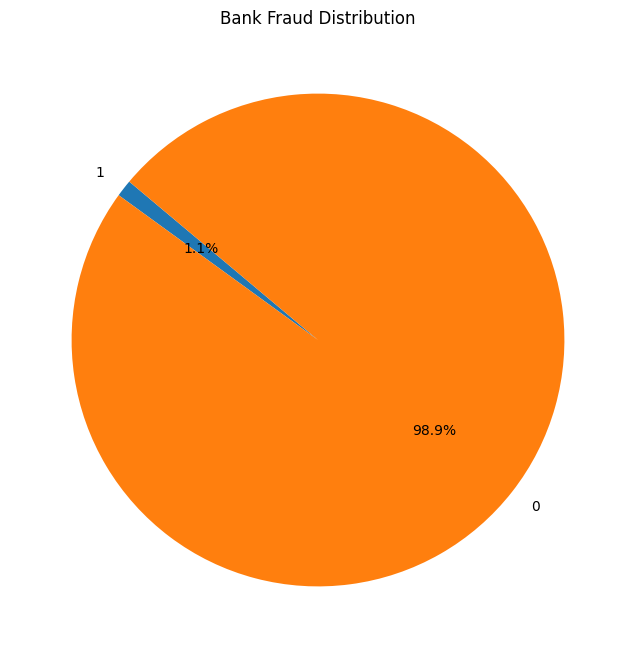

In [57]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_data_aggregated = data_aggregated.toPandas()

# Plot a pie chartimport matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(8, 8))

# Plot the pie chart
plt.pie(pandas_data_aggregated['count'], labels=pandas_data_aggregated['fraud_bool'], autopct='%1.1f%%', startangle=140)

# Set the title
plt.title('Bank Fraud Distribution')

# Display the plot
plt.show()

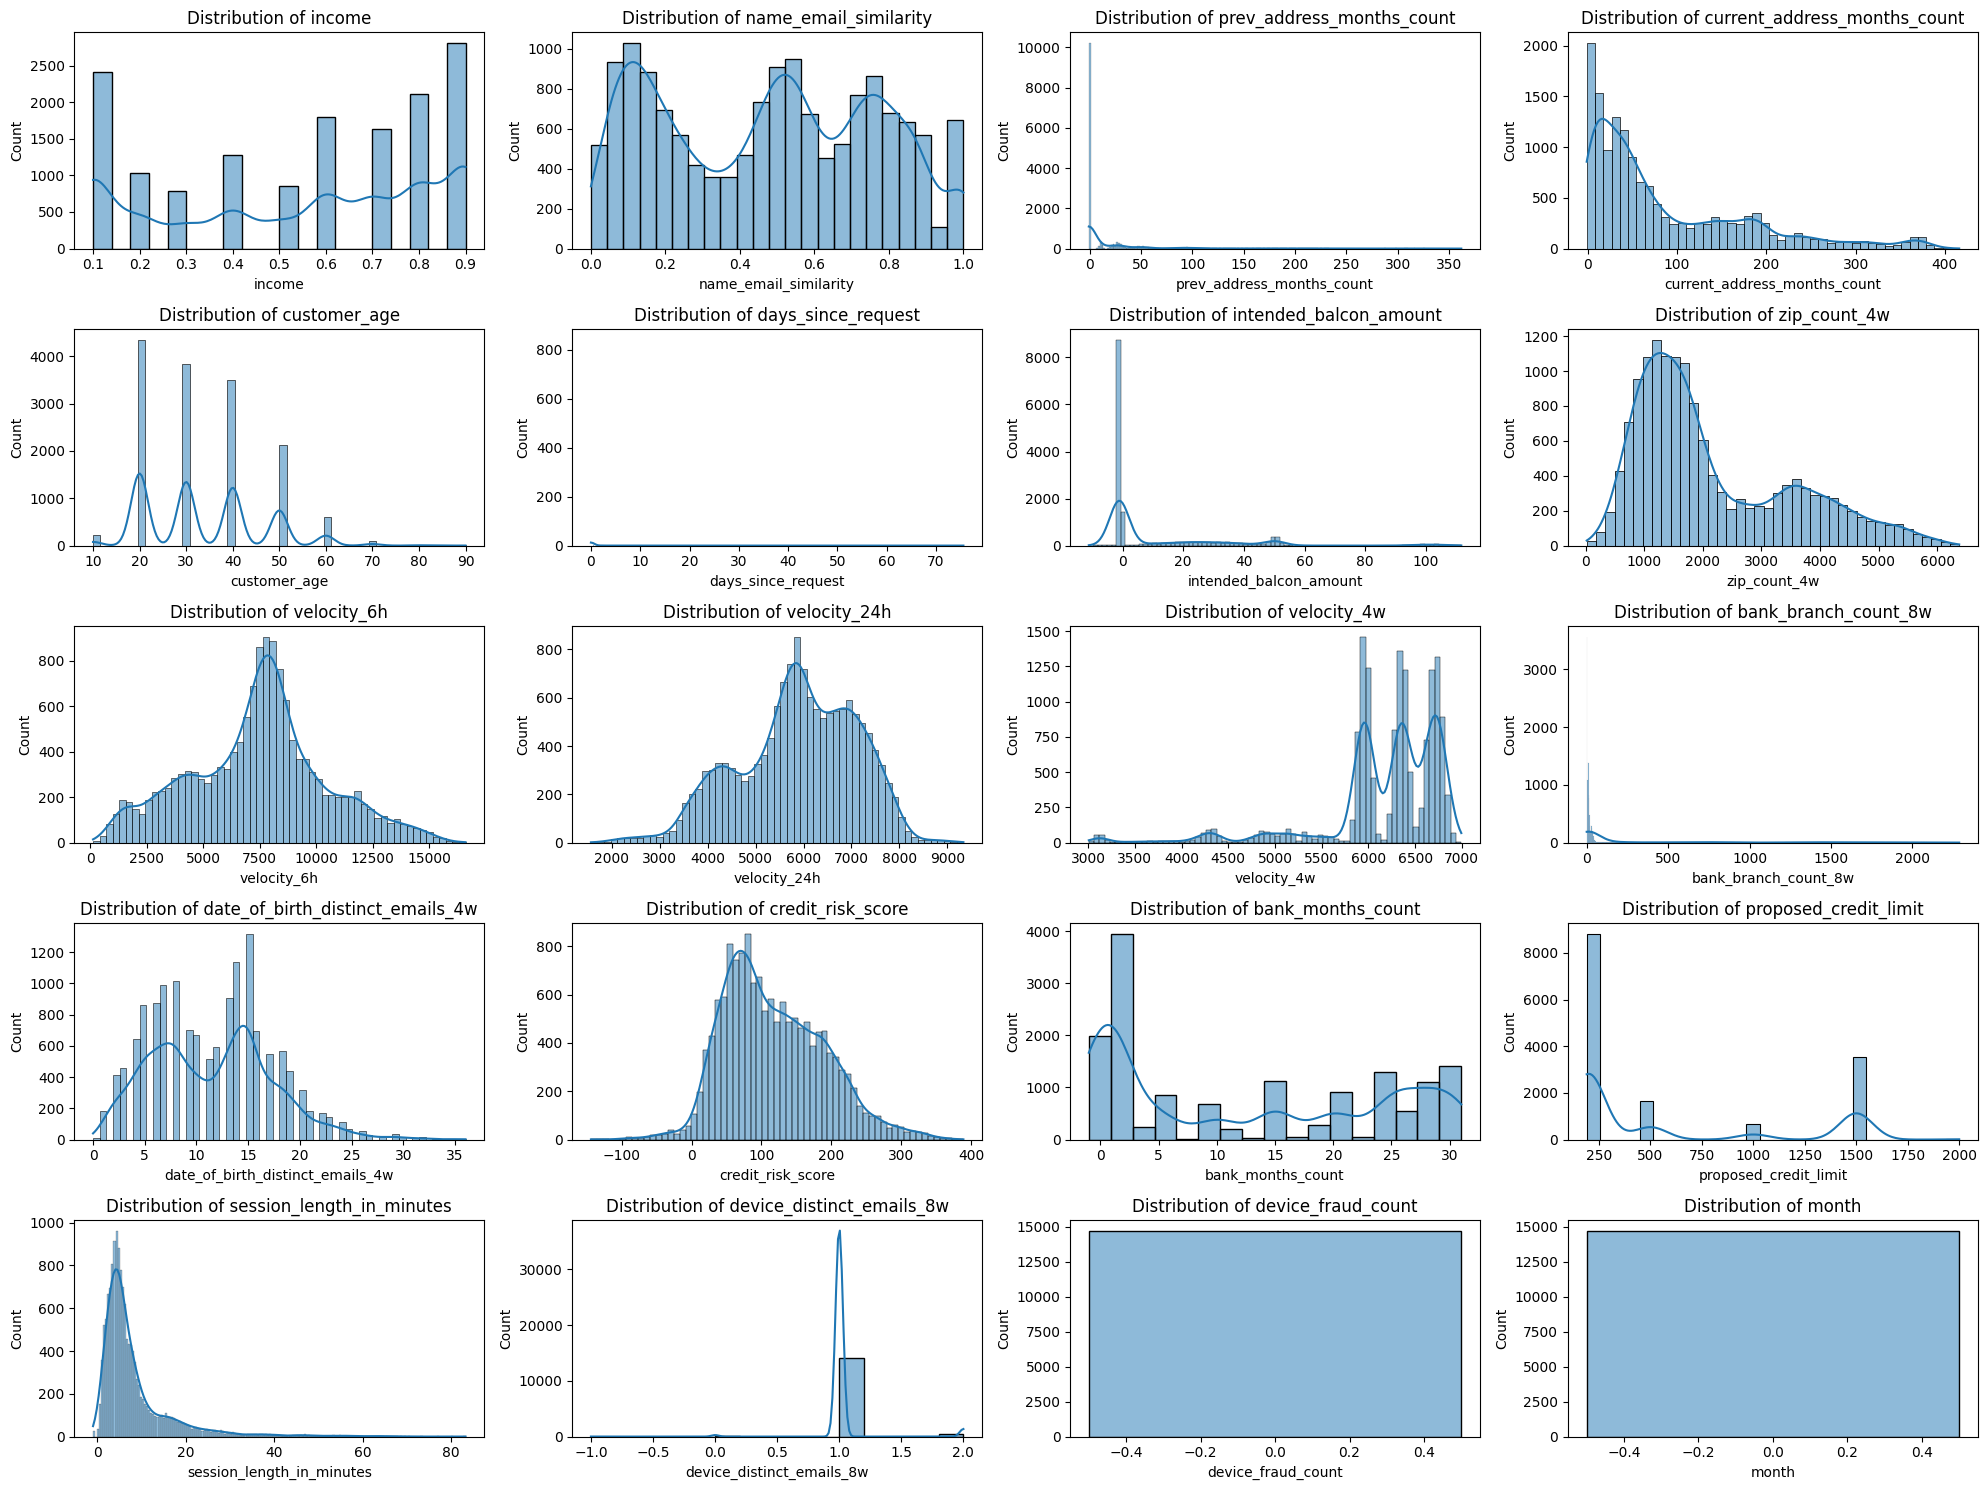

In [58]:
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_data = data.toPandas()

# Plot a histogram for each numerical feature
# Distribution of numerical features
numerical_features = ['income', 'name_email_similarity', 'prev_address_months_count',
                      'current_address_months_count', 'customer_age', 'days_since_request',
                      'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
                      'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
                      'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
                      'session_length_in_minutes', 'device_distinct_emails_8w', 'device_fraud_count',
                      'month']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(5, 4, i)
    sns.histplot(pandas_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [ ]:
#Building a XGBoost ML Model
# Convert categorical columns to numeric
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in ["payment_type", "employment_status", "housing_status", "source", "device_os"]]
pipeline = Pipeline(stages=indexers)
data_transformed = pipeline.fit(data).transform(data)

In [ ]:
# Assemble feature columns into a feature vector
feature_columns = [column for column in data_transformed.columns if column not in ["fraud_bool", "payment_type", "employment_status", "housing_status", "source", "device_os"]]
feature_columns += [column + "_index" for column in ["payment_type", "employment_status", "housing_status", "source", "device_os"]]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_transformed = assembler.transform(data_transformed)

In [ ]:
# Select the final DataFrame with features and label
final_df = data_transformed.select("features", "fraud_bool")

In [ ]:
# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
import numpy as np
import xgboost as xgb

# Convert the data to DMatrix format for XGBoost
train_features = np.array(train_df.select("features").collect())
train_labels = np.array(train_df.select("fraud_bool").collect())
test_features = np.array(test_df.select("features").collect())
test_labels = np.array(test_df.select("fraud_bool").collect())


In [ ]:
import numpy as np
import xgboost as xgb

# Convert the data to DMatrix format for XGBoost
# Extract features and flatten them into a 2D array
train_features = np.array([row['features'] for row in train_df.select("features").collect()])
train_labels = np.array(train_df.select("fraud_bool").collect()).flatten()  # Flatten labels as well
test_features = np.array([row['features'] for row in test_df.select("features").collect()])
test_labels = np.array(test_df.select("fraud_bool").collect()).flatten()

dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)

In [ ]:
# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (train_labels == 0).sum() / (train_labels == 1).sum()  # Handling class imbalance
}

In [ ]:
# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

In [ ]:
# Make predictions
preds = bst.predict(dtest)

In [ ]:
# Adjust the probability threshold for imbalanced data
threshold = 0.0005  # Adjusting the threshold.
adjusted_preds = (preds > threshold).astype(int)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)

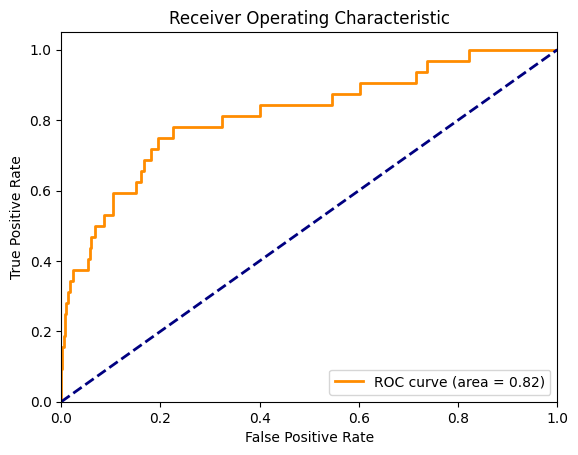

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluate the model using accuracy with adjusted threshold
accuracy = np.mean(adjusted_preds == test_labels)
print(f"Accuracy with adjusted threshold: {accuracy}")

Accuracy with adjusted threshold: 0.7748091603053435


In [ ]:
import pandas as pd
# Create a confusion matrix with adjusted threshold
confusion_matrix = pd.crosstab(test_labels, adjusted_preds, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0    1
Actual              
0          2208  642
1             7   25
